In [1]:
import torch, os, glob
import torch.nn as nn
import numpy as np
import tifffile as tiff
import umap
import matplotlib.pyplot as plt
from sklearn import manifold, datasets, metrics


def KLdivergence(x, y):
  """Compute the Kullback-Leibler divergence between two multivariate samples.
  Parameters
  ----------
  x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
  y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
  Returns
  -------
  out : float
    The estimated Kullback-Leibler divergence D(P||Q).
  References
  ----------
  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
  continuous distributions IEEE International Symposium on Information
  Theory, 2008.
  """
  from scipy.spatial import cKDTree as KDTree

  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

reducer = umap.UMAP()
gpu = True

# data_root = '/workspace/Data/womac4/full/'
# Change to your data root
data_root = '/home/ghc/Dataset/paired_images/womac4/full/'
# Change to your log root
#log_root = '/run/user/1000/gvfs/smb-share:server=changlab-nas.local,share=data/Data_GHC/OAI/contrastive_checkpoints/'
log_root = '/media/ExtHDD01/logs/womac4/'
# epoch
n_epoch = 200


In [2]:
## OPTION 1
#prj_name = '/global/1_project128/' # 0.90
#prj_name = '/global/1_project256_cosine/' #0.84
#prj_name = 'global1_cut1/nce4_down2_0011_ngf24_proj128/'
#prj_name = 'global1_cut1/nce4_down2_0011_ngf32_proj128_zcrop16/' # 0.88
#prj_name = 'global1_cut1/nce4_down2_0011_ngf24_proj128/' # 0.81
#prj_name = 'global1_cut1/nce4_down2_0011_ngf32_proj128_zcrop16_meanpool/' # bad
prj_name = 'global1_cut1/nce4_down4_0011_ngf32_proj32_zcrop16/'
force_no_projection = False # force to not use projection, or it will be used if .projection is in a model
use_eval = True
# OPTION 2
#prj_name = '/global/1_prj128/'
#force_no_projection = True  
#use_eval = True
 
net = torch.load(log_root + prj_name + 'checkpoints/net_g_model_epoch_' + str(n_epoch)  +'.pth', map_location='cpu')
if use_eval:
    net = net.eval()

if gpu:
    net = net.cuda()
pool = nn.AdaptiveMaxPool3d(output_size=(1, 1, 1))
try:
    projection = net.projection.cpu()
    print('With projection')
except:
    projection = None
    print('No projection')

With projection


In [3]:
alist = sorted(glob.glob(data_root + 'ap/*'))
blist = sorted(glob.glob(data_root + 'bp/*'))

In [4]:
all = []
for i in range(0, 667):
    print
    ax = alist[i*23 : (i+1)*23]
    bx = blist[i*23 : (i+1)*23]
    ax = [tiff.imread(x) for x in ax]
    bx = [tiff.imread(x) for x in bx]
    ax = np.stack(ax, 0)
    bx = np.stack(bx, 0)
    ax = ax / ax.max()
    bx = bx / bx.max()
    ax = torch.from_numpy(ax).float()
    bx = torch.from_numpy(bx).float()
    ax = ax.unsqueeze(1)
    bx = bx.unsqueeze(1)
    if gpu:
        ax = ax.cuda()
    ax = net(ax, alpha=1, method='encode')[-1].detach().cpu()
    if gpu:
        bx = bx.cuda()
    bx = net(bx, alpha=1, method='encode')[-1].detach().cpu()
    ax = ax.permute(1, 2, 3, 0).unsqueeze(0)
    bx = bx.permute(1, 2, 3, 0).unsqueeze(0)
    ax = pool(ax)[:, :, 0, 0, 0]
    bx = pool(bx)[:, :, 0, 0, 0]
    if (projection is not None) and (~force_no_projection):
        ax = projection(ax).detach().cpu()
        bx = projection(bx).detach().cpu()
    all.append(ax)
    all.append(bx)
    del ax
    del bx
all = torch.cat(all, 0)
all = all.numpy()
print(all.shape)

(1334, 32)


In [5]:
e0 = reducer.fit_transform(all)
e1 = manifold.TSNE(n_components=1, init='random', random_state=5, verbose=1).fit_transform(all)
e2 = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(all)
print(all.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1334 samples in 0.002s...
[t-SNE] Computed neighbors for 1334 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1334
[t-SNE] Computed conditional probabilities for sample 1334 / 1334
[t-SNE] Mean sigma: 0.163758
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.512135
[t-SNE] KL divergence after 1000 iterations: 0.772172
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1334 samples in 0.003s...
[t-SNE] Computed neighbors for 1334 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1334
[t-SNE] Computed conditional probabilities for sample 1334 / 1334
[t-SNE] Mean sigma: 0.163758
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.523060
[t-SNE] KL divergence after 1000 iterations: 0.506501
(1334, 32)


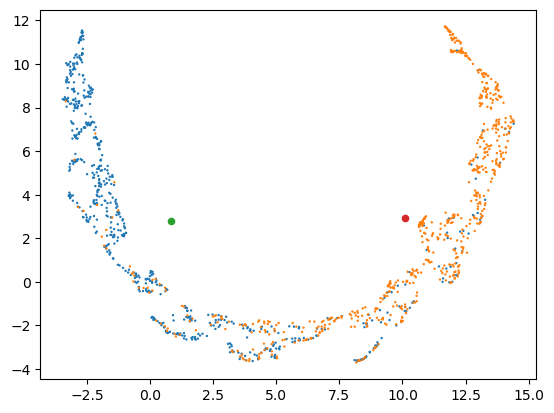

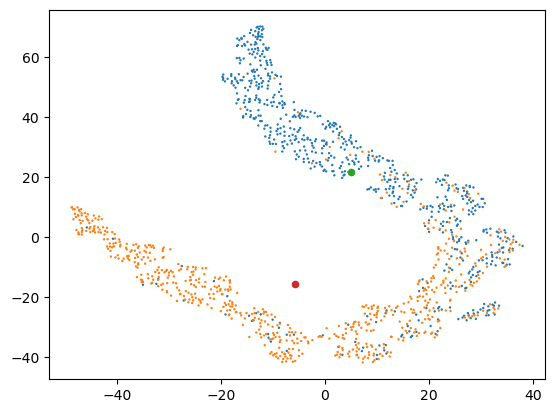

In [6]:
e = e0
plt.scatter(e[::2, 0], e[::2, 1], s=0.5*np.ones(e.shape[0] // 2))
plt.scatter(e[1::2, 0], e[1::2, 1], s=0.5*np.ones(e.shape[0] // 2))
# I was trying to plot the center of group here but as you can see, it's not always meaningful
plt.scatter(e[::2, 0].mean(0), e[::2, 1].mean(0), s=20*np.ones(1))
plt.scatter(e[1::2, 0].mean(0), e[1::2, 1].mean(0), s=20*np.ones(1))
plt.show()
try:
    e = e2
    plt.scatter(e[::2, 0], e[::2, 1], s=0.5*np.ones(e.shape[0] // 2))
    plt.scatter(e[1::2, 0], e[1::2, 1], s=0.5*np.ones(e.shape[0] // 2))
    # I was trying to plot the center of group here but as you can see, it's not always meaningful
    plt.scatter(e[::2, 0].mean(0), e[::2, 1].mean(0), s=20*np.ones(1))
    plt.scatter(e[1::2, 0].mean(0), e[1::2, 1].mean(0), s=20*np.ones(1))
    plt.show()
except:
    e = e1
    plt.scatter(e[::2, 0], np.random.rand(e[::2,0].shape[0]), s=0.5*np.ones(e.shape[0] // 2))
    plt.scatter(e[1::2, 0], np.random.rand(e[::2,0].shape[0]), s=0.5*np.ones(e.shape[0] // 2))
    # I was trying to plot the center of group here but as you can see, it's not always meaningful
    plt.ylim(-5, 5)
    plt.show()
    

10.949021212058005
1.8686115595813189
global1_cut1/nce4_down4_0011_ngf32_proj32_zcrop16/
0.07877021009735012


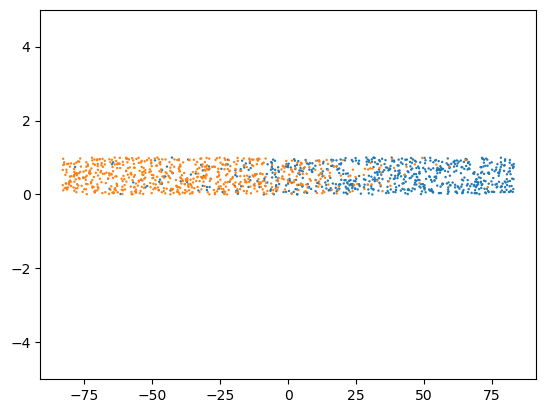

In [7]:
kl = KLdivergence(all[::2, :], all[1::2, :])
print(kl)
kl = KLdivergence(e1[::2, :], e1[1::2, :])
print(kl)
auc = metrics.roc_auc_score(np.concatenate([0 * np.ones(e1.shape[0] // 2), 1 * np.ones(e1.shape[0] // 2)]), np.concatenate([e1[::2, 0], e1[1::2, 0]]))
print(prj_name)
print(auc)
e = e1
plt.scatter(e[::2, 0], np.random.rand(e[::2,0].shape[0]), s=0.5*np.ones(e.shape[0] // 2))
plt.scatter(e[1::2, 0], np.random.rand(e[::2,0].shape[0]), s=0.5*np.ones(e.shape[0] // 2))
# I was trying to plot the center of group here but as you can see, it's not always meaningful
plt.ylim(-5, 5)
plt.show()

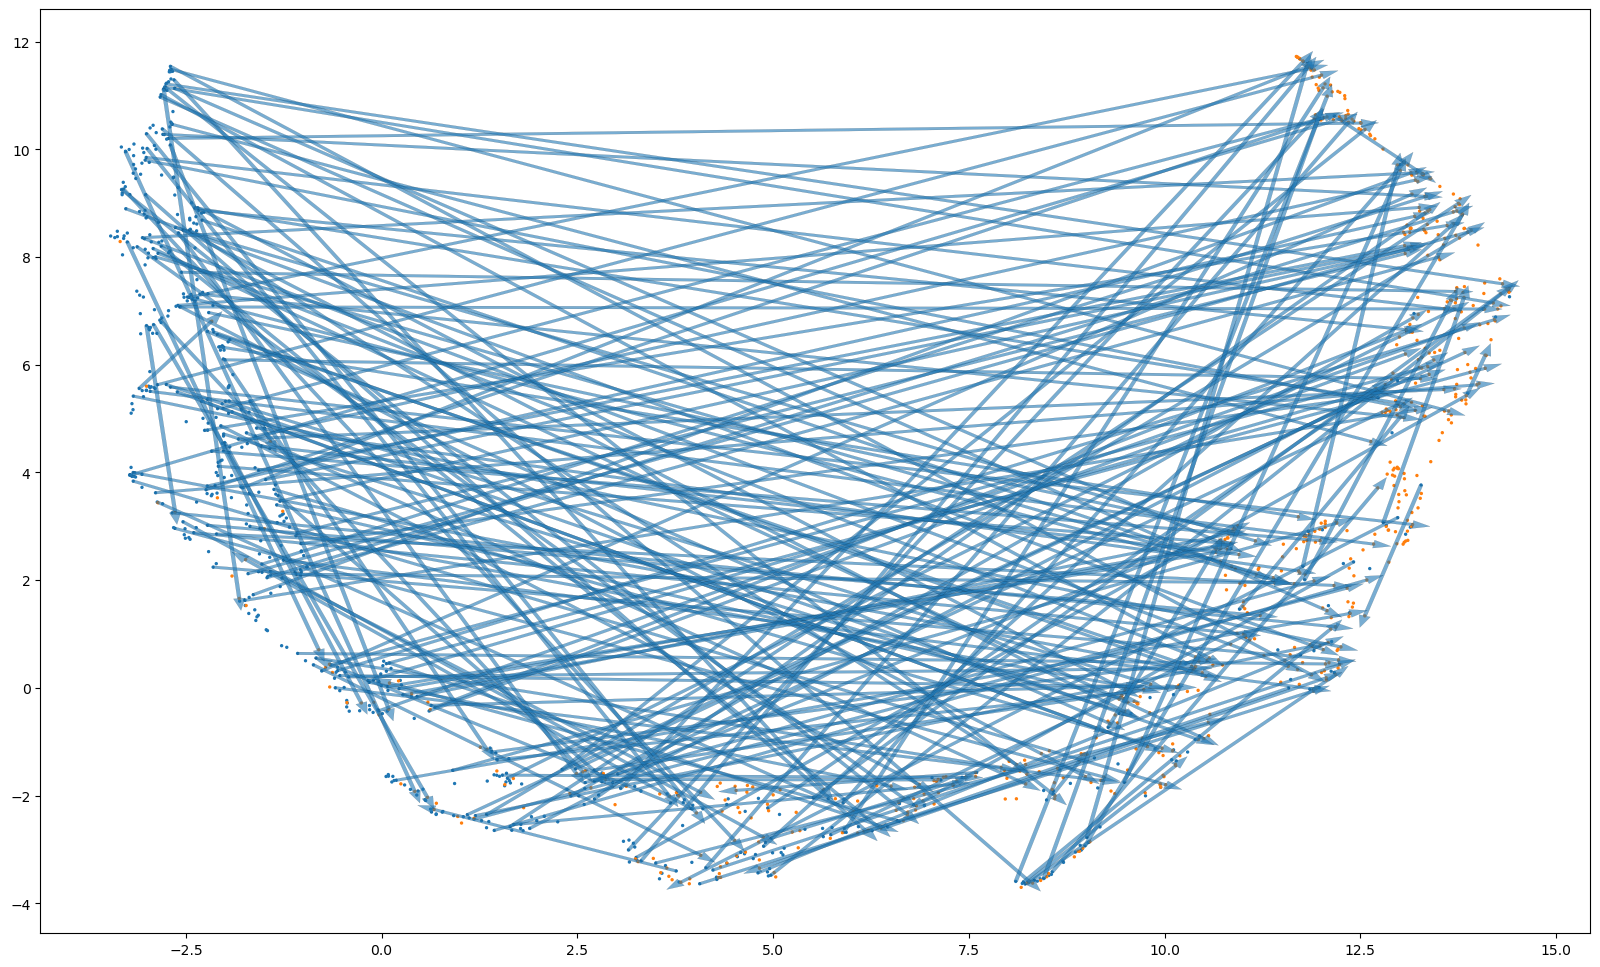

In [9]:
if 1:
    plt.figure(figsize=(20,12))
    e = e0
    eA = e[::2, :]
    eB = e[1::2, :]
    plt.scatter(e[::2, 0], e[::2, 1], s=2*np.ones(e.shape[0] // 2))
    plt.scatter(e[1::2, 0], e[1::2, 1], s=2*np.ones(e.shape[0] // 2))
    for i in range(200):
        plt.arrow(eA[i, 0], eA[i, 1], eB[i, 0] - eA[i, 0], eB[i, 1] - eA[i, 1], alpha=0.6, linewidth=0.1, width=0.05)
    plt.show()